In [1]:
from IPython import get_ipython


# Segment Lights
In this notebook, the model the Christmas tree is calculated from a set of video recordings.

In [2]:
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')


In [3]:
# Identify start and end of recording

import cv2
import numpy as np
import matplotlib.pyplot as plt

from xmas_lights import TreeDetector

videoPath = ['/notebooks/xmas_tree_videos/tree_calib_01.MP4',
             '/notebooks/xmas_tree_videos/tree_calib_02.MP4',
             '/notebooks/xmas_tree_videos/tree_calib_03.MP4',
             '/notebooks/xmas_tree_videos/tree_calib_04.MP4',
             '/notebooks/xmas_tree_videos/tree_calib_05.MP4']
time_start_aprox = [4, 7, 1, 6, 7]
output_images = ['/notebooks/xmas_tree_videos/pics/tree_calib_01_%05d.jpg',
                 '/notebooks/xmas_tree_videos/pics/tree_calib_02_%05d.jpg',
                 '/notebooks/xmas_tree_videos/pics/tree_calib_03_%05d.jpg',
                 '/notebooks/xmas_tree_videos/pics/tree_calib_04_%05d.jpg',
                 '/notebooks/xmas_tree_videos/pics/tree_calib_05_%05d.jpg']



In [4]:

imgpoints = []
imgs = []

for ipov in range(5):
    td = TreeDetector(videoPath[ipov])

    td.set_time(time_start_aprox[ipov])
    time_start = td.find_flash_events()

    td.set_time(time_start)
    ret, frame = td.read()
    imgs.append(frame)

    imgp = []

    for itime in time_start + td.flash_pattern_time:
        td.set_time(itime)
        ret, frame = td.read()

        img_point, area, _ = td.segment(frame)
        imgp.append(img_point)

        if area > 0:
            center = tuple(np.round(img_point).astype(int))
            radius = np.round(np.sqrt(area / np.pi)).astype(int)
            frame = cv2.circle(frame, center, radius, (0, 0, 255), 3)

        cv2.imwrite(output_images[ipov] % (round(itime*1e3)), frame)

    imgpoints.append(np.reshape(imgp, (-1, 1, 2)))


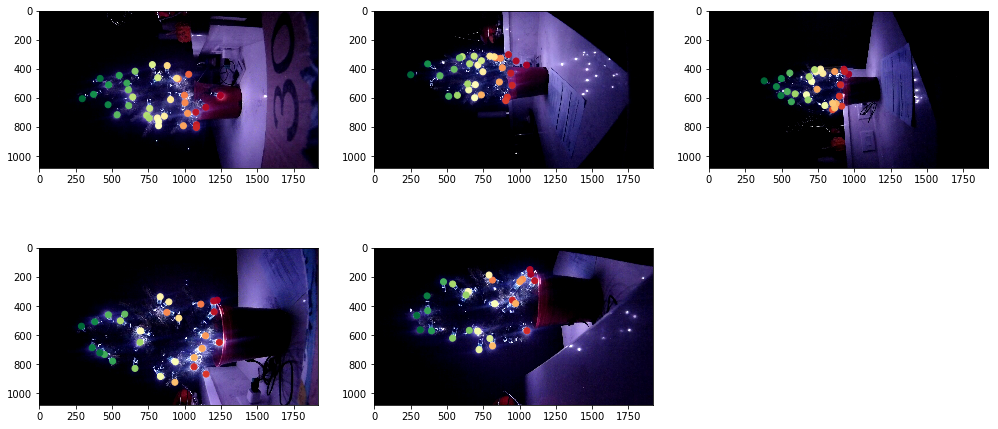

In [5]:
import pickle
from xmas_lights import plot_images

plot_images(imgs, imgpoints)

# Save calibration in file
dataset = {"imgpoints": imgpoints, "imgs": imgs}
outfile = open('tree_dataset.pickle', 'wb')
pickle.dump(dataset, outfile)
outfile.close()


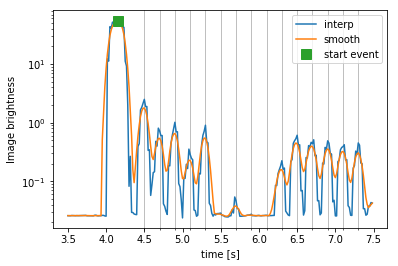

In [6]:

td = TreeDetector(videoPath[0])
td.set_time(time_start_aprox[0] + 1.5)

time_start = td.find_flash_events(viz=True, time_tol=2)

ax = plt.gca()
ax.set_xticks(time_start + td.flash_pattern_time[:15], minor=True)
ax.xaxis.grid(True, which='minor')
plt.show()


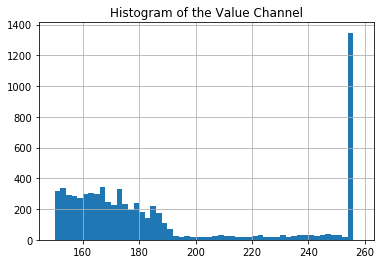

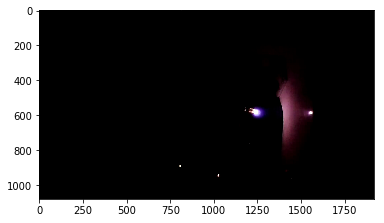

In [7]:
# Selecting the threshold value for segmentation

# move to first light flash and read frame
td.set_time(time_start + td.flash_pattern_time[0])
_, frame = td.read()

# Select [V]alue channel
img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
value = img[:,:,2]  # goes from 0 to 255

plt.figure()
plt.hist(value.reshape(-1), bins=np.arange(150, 260, 2))
plt.title('Histogram of the Value Channel')
plt.grid()
plt.show()

plt.figure()
plt.imshow(frame)
plt.show()

thresh = 240


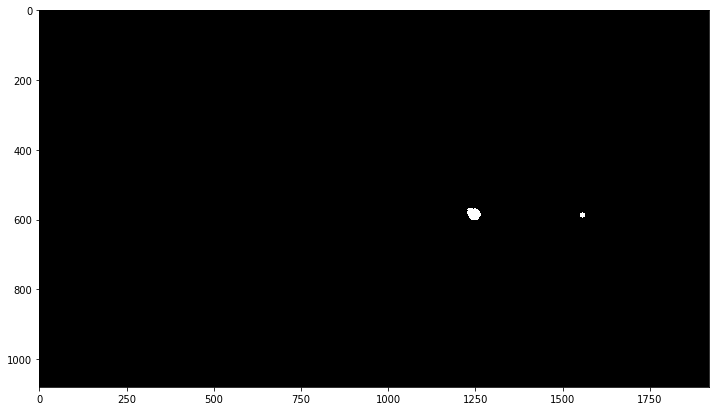

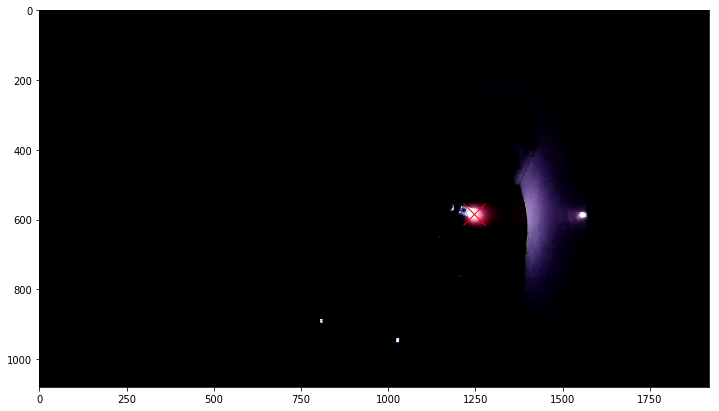

In [8]:
# Show segmentation results
td.set_time(time_start + td.flash_pattern_time[0])
_, frame = td.read()

td.segment(frame, viz_mode=1)
td.segment(frame, viz_mode=2);
